# What's in this notebook
- Correlations with monthly indicators and topic modelling results (see topic_modelling notebook).
- Exploratory - was discarded as findings were not strong and the team's work went in another direction.

# Libraries

In [96]:
# Import relevant libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.formula.api import ols
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pylab
import scipy.stats as stats
from scipy.stats import pearsonr

# Functions

In [98]:
# Function to create a scatter plot with a regression line

def reg_plt(x, y, y_pred, ind_name, dep_name, filename=None):
    # Set fig size
    plt.figure(figsize=(7,7))
    
    # Plot scatter and regression line
    plt.scatter(x, y, alpha=0.5, color='#3CD7D9')
    plt.plot(x, y_pred, color='#0d1b2c')
    
    # Set axis limits based on data
    plt.xlim(min(x) - 0.05, max(x) + 0.05)
    plt.ylim(min(y) - 0.1, max(y) + 0.1)
    
    # Remove axis lines on right and top
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    
    # Set titles and labels
    plt.ylabel(dep_name)
    plt.xlabel(ind_name)
    plt.title(f"{dep_name} vs {ind_name}")
    plt.tight_layout()
    
    # Save file
    if filename:
        plt.savefig(filename, dpi=300)
        
    plt.show()

# Data import

In [100]:
# Load monthly indicators
month = pd.read_csv('sentiments_topics_monthly_indicators.csv')
month.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 670 entries, 0 to 669
Data columns (total 50 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   date                     664 non-null    object 
 1   custom_ref               664 non-null    object 
 2   reference                516 non-null    object 
 3   title                    664 non-null    object 
 4   author                   664 non-null    object 
 5   is_gov                   664 non-null    float64
 6   text                     664 non-null    object 
 7   finbert_pos              664 non-null    float64
 8   finbert_neg              664 non-null    float64
 9   finbert_neu              664 non-null    float64
 10  finbert_sentiment        664 non-null    object 
 11  finbert_score            664 non-null    float64
 12  finbert_confidence       664 non-null    float64
 13  central_bank             664 non-null    float64
 14  financial_sector         6

# Explore relationship between inflation topic (topic 7) and CPI rate

In [102]:
# Subset needed cols
month_sub = month[['date', 'custom_ref', 'cpi_rate', 'topic_7']].copy().reset_index(drop=True)

print(month_sub.info())
month_sub.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 670 entries, 0 to 669
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        664 non-null    object 
 1   custom_ref  664 non-null    object 
 2   cpi_rate    670 non-null    float64
 3   topic_7     664 non-null    float64
dtypes: float64(2), object(2)
memory usage: 21.1+ KB
None


,date,custom_ref,cpi_rate,topic_7
0,2015-01-20,UK_2015-01-20_cunliffe,0.3,0.000063
1,2015-01-22,UK_2015-01-22_fisher,0.3,0.024934
2,2015-01-22,UK_2015-01-22_miles,0.3,0.770376
3,2015-01-23,UK_2015-01-23_gracie,0.3,0.000126
4,2015-01-26,UK_2015-01-26_forbes,0.3,0.448039
5,2015-01-28,UK_2015-01-28_Carney,0.3,0.314868
6,2015-01-29,UK_2015-01-29_hauser,0.3,0.000068
7,2015-02-11,UK_2015-02-11_furse,0.0,0.000079
8,2015-02-17,UK_2015-02-17_haldane,0.0,0.000044
9,2015-02-24,UK_2015-02-24_forbes,0.0,0.443185


In [103]:
# Convert to date time
month_sub['date'] = pd.to_datetime(month_sub['date'])

month_sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 670 entries, 0 to 669
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        664 non-null    datetime64[ns]
 1   custom_ref  664 non-null    object        
 2   cpi_rate    670 non-null    float64       
 3   topic_7     664 non-null    float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 21.1+ KB


In [104]:
# Create year-month col
month_sub['year_month'] = month_sub['date'].dt.strftime('%Y-%m')

month_sub.sample(3)

,date,custom_ref,cpi_rate,topic_7,year_month
56,2015-10-10,UK_2015-10-10_shafik,-0.1,0.248330,2015-10
416,2021-01-11,UK_2021-01-11_tenreyro,0.7,0.582918,2021-01
220,2018-02-01,UK_2018-02-01_brazier,2.7,0.000050,2018-02


## Exploratory viz

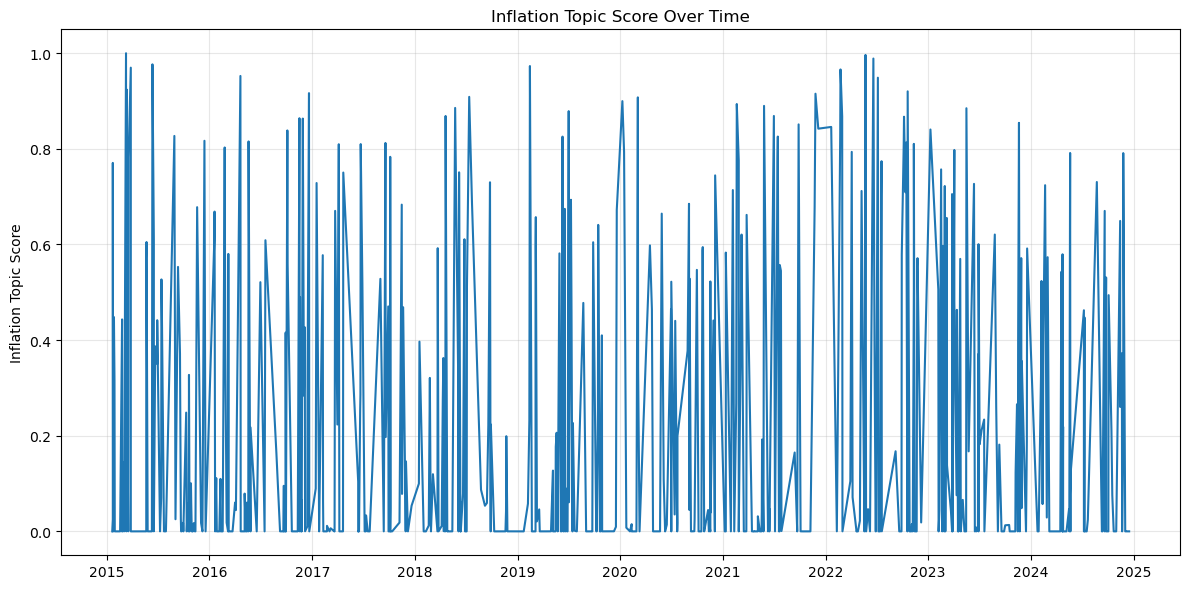

In [106]:
# Plot inflation topic score over time
plt.figure(figsize=(12,6))
# plt.scatter(month_sub['date'], month_sub['topic_7'])
plt.plot(month_sub['date'], month_sub['topic_7'])

# Titles and format
plt.title('Inflation Topic Score Over Time')
plt.ylabel('Inflation Topic Score')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

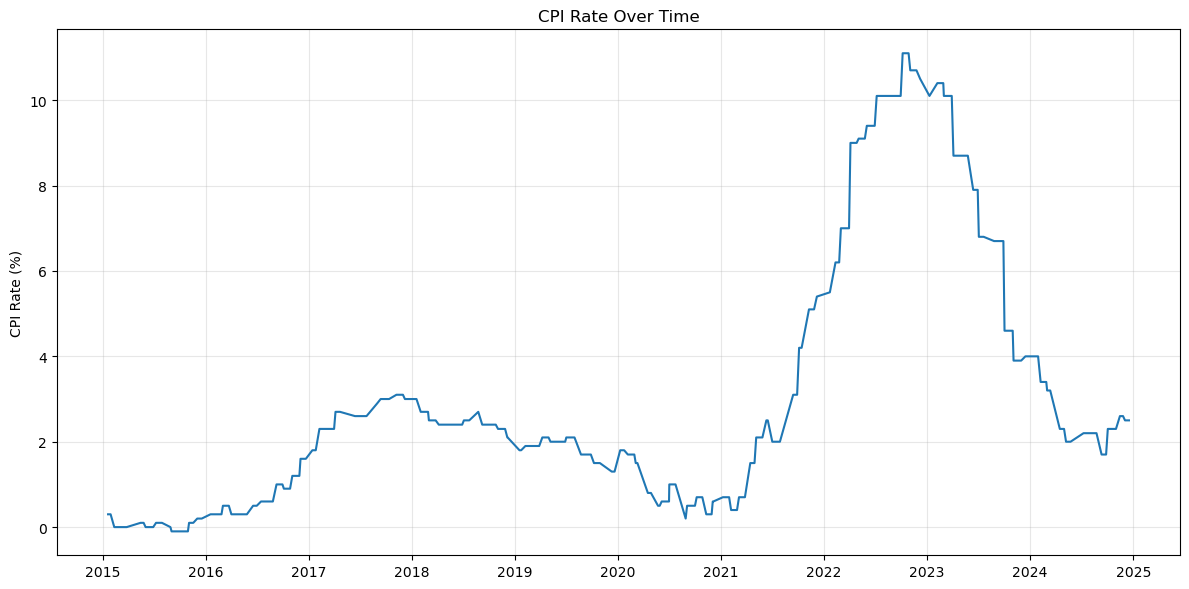

In [107]:
# Plot CPI rate over time
plt.figure(figsize=(12,6))
plt.plot(month_sub['date'], month_sub['cpi_rate'])

# Titles and format
plt.title('CPI Rate Over Time')
plt.ylabel('CPI Rate (%)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Correlations between inflation topic and CPI

### No lag

In [110]:
# Group by month
monthly_data = month_sub.groupby('year_month').agg(
    mean_topic_7=('topic_7', 'mean'),
    max_topic_7=('topic_7', 'max'),
    speech_count=('topic_7', 'count'),
    last_cpi=('cpi_rate', 'last')  
).reset_index().copy()

# Convert to datetime
monthly_data['date'] = pd.to_datetime(monthly_data['year_month'] + '-01')
monthly_data = monthly_data.sort_values('date')

monthly_data.head()

,year_month,mean_topic_7,max_topic_7,speech_count,last_cpi,date
0,2015-01,0.222639,0.770376,7,0.3,2015-01-01
1,2015-02,0.084058,0.443185,7,0.0,2015-02-01
2,2015-03,0.450904,0.999688,11,0.0,2015-03-01
3,2015-05,0.235171,0.604972,5,0.1,2015-05-01
4,2015-06,0.307348,0.976464,9,0.0,2015-06-01


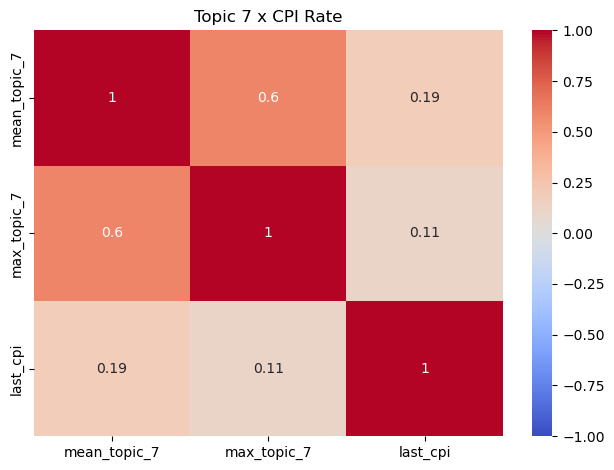

In [111]:
# View correlations
corr = monthly_data[['mean_topic_7', 'max_topic_7', 'last_cpi']].corr()

sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Topic 7 x CPI Rate')
plt.tight_layout()
plt.show()

## Lagged

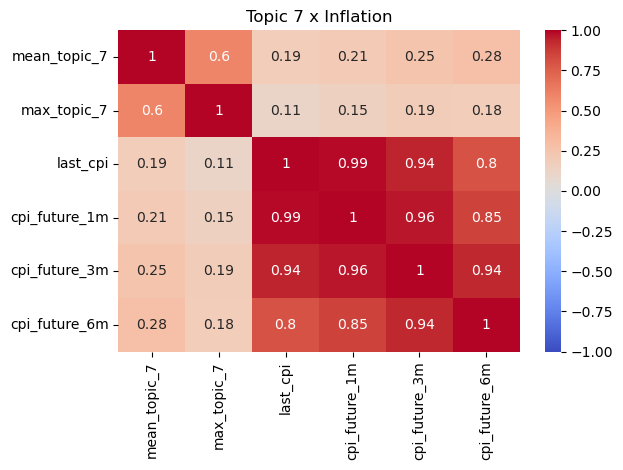

In [113]:
# Lagged version
for lag in [1, 3, 6]:
    monthly_data[f'cpi_future_{lag}m'] = monthly_data['last_cpi'].shift(-lag)

# Calculate correlation
future_corr = monthly_data[['mean_topic_7', 'max_topic_7', 'last_cpi', 
                           'cpi_future_1m', 'cpi_future_3m', 'cpi_future_6m']].corr()

sns.heatmap(future_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Topic 7 x Inflation')

plt.tight_layout()
plt.show()

**Observation:** There is little correlation between Inflation Topic (Topic 7) and CPI rate in these correlations.

Correlation between change in inflation topic and CPI rate:


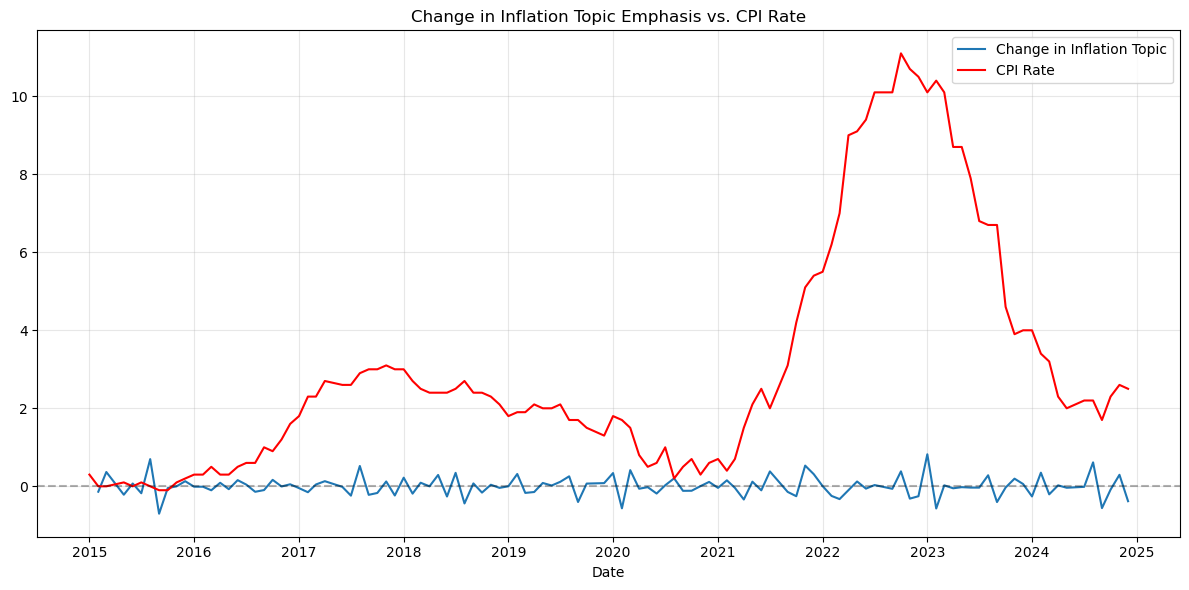

In [115]:
# Calculate change in inflation topic emphasis
monthly_data['topic_7_change'] = monthly_data['mean_topic_7'].diff()

# Check correlation with CPI
change_corr = monthly_data[['topic_7_change', 'last_cpi']].corr()
print("Correlation between change in inflation topic and CPI rate:")

# Visualize
plt.figure(figsize=(12, 6))
plt.plot(monthly_data['date'], monthly_data['topic_7_change'], label='Change in Inflation Topic')
plt.plot(monthly_data['date'], monthly_data['last_cpi'], label='CPI Rate', color='red')
plt.axhline(y=0, color='black', linestyle='--', alpha=0.3)
plt.title('Change in Inflation Topic Emphasis vs. CPI Rate')
plt.legend()
plt.xlabel('Date')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Correlation between high inflation topic periods and CPI rate:
              topic_7_high  last_cpi
topic_7_high      1.000000  0.163425
last_cpi          0.163425  1.000000


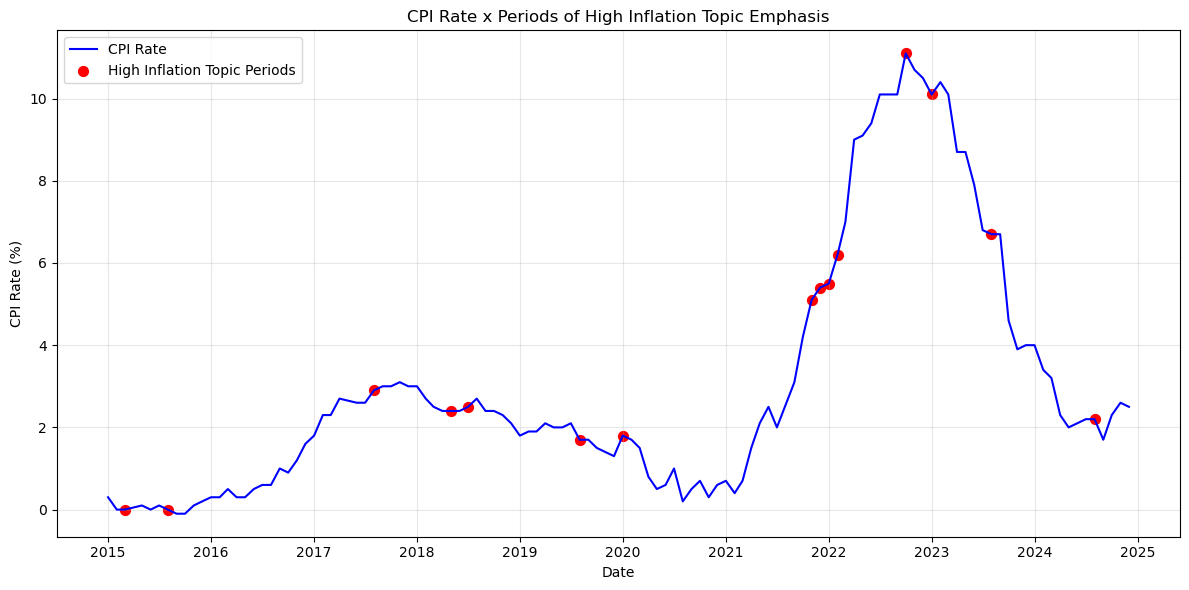

In [128]:
# Calculate threshold for "high inflation topic" periods
threshold = monthly_data['mean_topic_7'].mean() + monthly_data['mean_topic_7'].std()
monthly_data['topic_7_high'] = (monthly_data['mean_topic_7'] > threshold).astype(int)

# Check if "high inflation topic" periods correlate with inflation rates
high_corr = monthly_data[['topic_7_high', 'last_cpi']].corr()
print("Correlation between high inflation topic periods and CPI rate:")
print(high_corr)

# Show times with high inflation topic 
plt.figure(figsize=(12, 6))
plt.plot(monthly_data['date'], monthly_data['last_cpi'], label='CPI Rate', color='blue')
plt.scatter(monthly_data.loc[monthly_data['topic_7_high'] == 1, 'date'],
           monthly_data.loc[monthly_data['topic_7_high'] == 1, 'last_cpi'],
           color='red', s=50, label='High Inflation Topic Periods')
plt.title('CPI Rate x Periods of High Inflation Topic Emphasis')
plt.legend()
plt.xlabel('Date')
plt.ylabel('CPI Rate (%)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# All variables
Going broader with a look at all topics, sentiment, and indicators

In [130]:
month = month.dropna(subset=['date'])

# Convert to datetime
month['date'] = pd.to_datetime(month['date'])

# Extract topic columns
topic_columns = [col for col in month.columns if col.startswith('topic_')]

# Extract economic indicator columns
exclude_columns = ['date', 'custom_ref', 'reference', 'title', 'author', 'is_gov', 'text', 
                   'finbert_sentiment', 'dominant_topic_name', 'month']
                   
indicator_columns = [col for col in month.columns if 
                    col not in exclude_columns and 
                    col not in topic_columns and
                    col != 'dominant_topic' and
                    month[col].dtype != 'object']

# Agg by month
# Create year_month col
month['year_month'] = month['date'].dt.strftime('%Y-%m')

agg_dict = {}
for col in topic_columns:
    agg_dict[col] = 'mean'

# Add sentiment columns 
sentiment_columns = ['finbert_pos', 'finbert_neg', 'finbert_neu', 'finbert_score', 
                     'finbert_confidence', 'cbroberta_avg_score', 'cbroberta_avg_sentiment']
for col in sentiment_columns:
    if col in month.columns:
        agg_dict[col] = 'mean'

# Take last value in month for indicators
for col in indicator_columns:
    if col not in sentiment_columns:
        agg_dict[col] = 'last'

# Aggregate by month
monthly_data = month.groupby('year_month').agg(agg_dict).reset_index().copy()

# Convert year_month back to datetime
monthly_data['date'] = pd.to_datetime(monthly_data['year_month'] + '-01')

# Create lagged versions of core indicators
lag_periods = [1, 3, 6]  
for indicator in ['cpi_rate', 'hpi_yoy', 'unemp_rate', 'wage_rate', 'mortgage_2yr']:
    if indicator in monthly_data.columns:
        for lag in lag_periods:
            monthly_data[f'{indicator}_future_{lag}m'] = monthly_data[indicator].shift(-lag)

# Create correlation matrix
extended_indicators = indicator_columns + [f'{ind}_future_{lag}m' for ind in 
                                         ['cpi_rate', 'hpi_yoy', 'unemp_rate', 'wage_rate', 'mortgage_2yr']
                                         for lag in lag_periods if f'{ind}_future_{lag}m' in monthly_data.columns]

corr_matrix = monthly_data[topic_columns + extended_indicators].corr()

# Extract topics and indicators
topic_indicator_corr = corr_matrix.loc[topic_columns, extended_indicators]

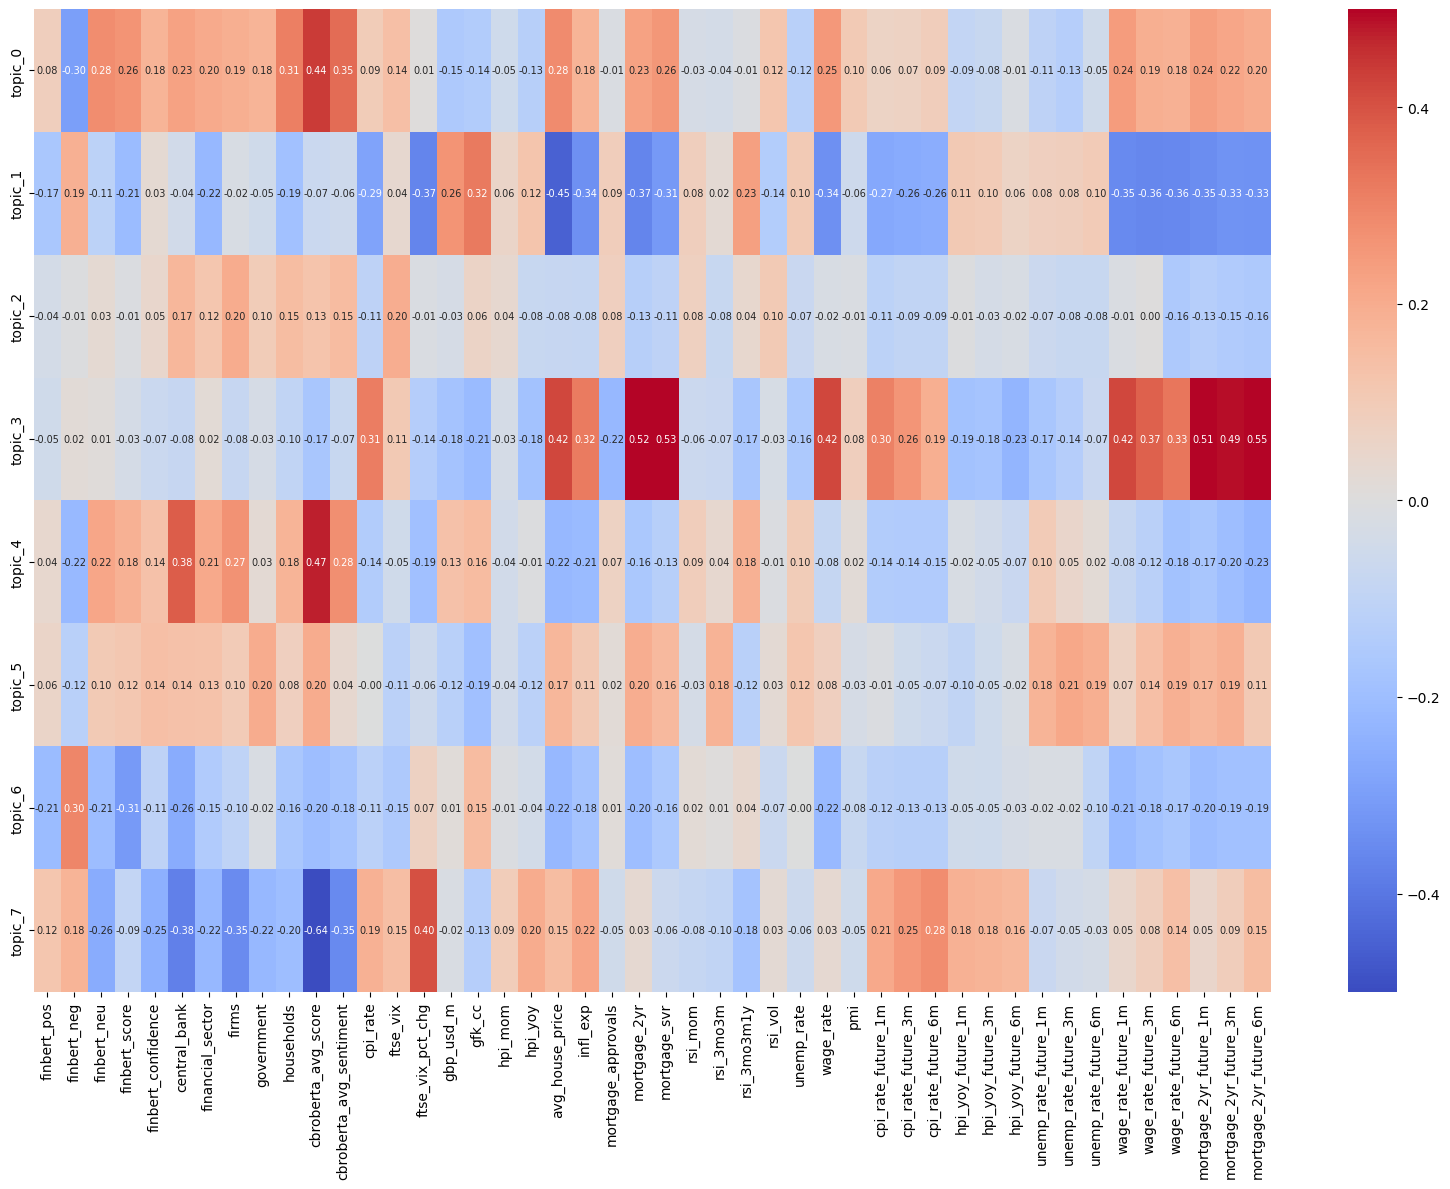

In [31]:
# Show correlations
plt.figure(figsize=(16, 12))
sns.heatmap(topic_indicator_corr, annot=True, cmap='coolwarm', vmin=-0.5, vmax=0.5, center=0, fmt='.2f',
           annot_kws={"size": 7})
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [134]:
# Find strongest correlations

corr_pairs = []
for topic in topic_columns:
    for indicator in extended_indicators:
        corr_value = corr_matrix.loc[topic, indicator]
        # Skip NA
        if not np.isnan(corr_value):
            corr_pairs.append((topic, indicator, corr_value))

# Convert to df and sort
corr_df = pd.DataFrame(corr_pairs, columns=['Topic', 'Indicator', 'Correlation'])
corr_df['Abs_Correlation'] = corr_df['Correlation'].abs()
corr_df = corr_df.sort_values('Abs_Correlation', ascending=False)

# Print the top correlations
print(corr_df.head(20))

       Topic               Indicator  Correlation  Abs_Correlation
332  topic_7     cbroberta_avg_score    -0.638125         0.638125
183  topic_3  mortgage_2yr_future_6m     0.548560         0.548560
161  topic_3            mortgage_svr     0.534628         0.534628
160  topic_3            mortgage_2yr     0.515600         0.515600
181  topic_3  mortgage_2yr_future_1m     0.512703         0.512703
182  topic_3  mortgage_2yr_future_3m     0.491983         0.491983
194  topic_4     cbroberta_avg_score     0.472772         0.472772
65   topic_1         avg_house_price    -0.449684         0.449684
10   topic_0     cbroberta_avg_score     0.438201         0.438201
167  topic_3               wage_rate     0.421306         0.421306
178  topic_3     wage_rate_future_1m     0.419848         0.419848
157  topic_3         avg_house_price     0.419593         0.419593
336  topic_7        ftse_vix_pct_chg     0.404433         0.404433
189  topic_4            central_bank     0.380308         0.38

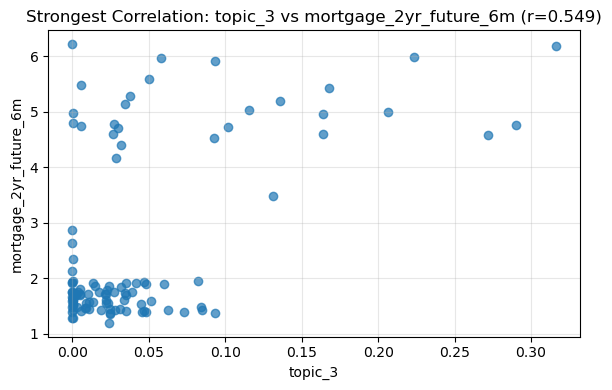

In [136]:
# Visualise strongest correlation (outside of sentiment-sentiment correlations)
top_corr = corr_df.iloc[1]
topic = top_corr['Topic']
indicator = top_corr['Indicator']

plt.figure(figsize=(6,4))
plt.scatter(monthly_data[topic], monthly_data[indicator], alpha=0.7)
plt.title(f'Strongest Correlation: {topic} vs {indicator} (r={top_corr["Correlation"]:.3f})')
plt.xlabel(topic)
plt.ylabel(indicator)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [34]:
# Run Granger test
granger_data = month[['date', topic, 'mortgage_2yr']].dropna().sort_values('date').set_index('date')

# Run Granger causality test with 12 month maximum lag
gc_result = grangercausalitytests(granger_data, maxlag=12, verbose=False)

# Display results
for lag, result in gc_result.items():
    p_value = result[0]['ssr_ftest'][1]  # p-value from F-test
    significance = ' *' if p_value < 0.05 else ''
    print(f"Lag {lag}: p-value = {p_value:.4f}{significance}")

Lag 1: p-value = 0.0000 *
Lag 2: p-value = 0.0000 *
Lag 3: p-value = 0.0000 *
Lag 4: p-value = 0.0000 *
Lag 5: p-value = 0.0000 *
Lag 6: p-value = 0.0000 *
Lag 7: p-value = 0.0000 *
Lag 8: p-value = 0.0000 *
Lag 9: p-value = 0.0001 *
Lag 10: p-value = 0.0000 *
Lag 11: p-value = 0.0001 *
Lag 12: p-value = 0.0001 *


C:\Users\katej\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


In [139]:
# Drop NA
monthly_clean = monthly_data[['topic_3', 'mortgage_2yr_future_6m']].dropna().reset_index().copy()

# Create variables 
y = monthly_clean['mortgage_2yr_future_6m']  
x = monthly_clean['topic_3']  

# Create model and print summary of metrics
model = ols('y ~ x', data=monthly_clean).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.301
Model:                            OLS   Adj. R-squared:                  0.294
Method:                 Least Squares   F-statistic:                     45.63
Date:                Mon, 26 May 2025   Prob (F-statistic):           7.95e-10
Time:                        17:12:24   Log-Likelihood:                -180.23
No. Observations:                 108   AIC:                             364.5
Df Residuals:                     106   BIC:                             369.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.9737      0.150     13.157      0.0

In [141]:
# Get coefficient and direction
coef = model.params['x']
direction = "INCREASE" if coef > 0 else "DECREASE"
print(f"\nTopic 3 coefficient: {coef:.4f}")
print(f"Direction: Higher Topic 3 presence predicts mortgage rate {direction} in 6 months")
print(f"p-value: {model.pvalues['x']:.6f}")


Topic 3 coefficient: 13.5829
Direction: Higher Topic 3 presence predicts mortgage rate INCREASE in 6 months
p-value: 0.000000


In [159]:
# Generate predictions
y_pred_clean = model.predict()

In [161]:
# Run the Breusch-Pagan test f
test = sms.het_breuschpagan(model.resid, model.model.exog)

# Print the results.
terms = ['LM stat', 'LM Test p-value', 'F-stat', 'F-test p-value']
print(dict(zip(terms, test)))

{'LM stat': 0.007152373341789975, 'LM Test p-value': 0.9326018943345403, 'F-stat': 0.007020386913495295, 'F-test p-value': 0.9333832214536363}


**Observation:** Homoscedasticity is present in the mode, which is good.

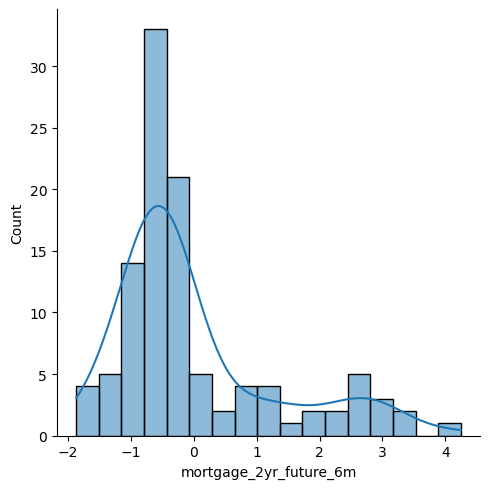

In [163]:
# Calculate residuals
residuals = y - model.predict()

# Plot residuals distribution with a histogram
sns.displot(residuals, kde=True)
plt.show()

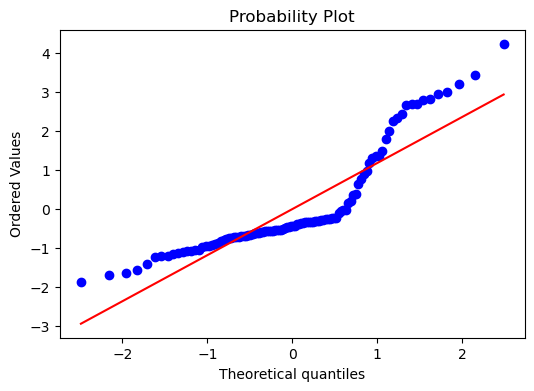

In [165]:
# Plot residuals with a Q-Q plot
plt.figure(figsize=(6,4))
stats.probplot(residuals, dist='norm', plot=pylab)
plt.show()

In [167]:
# Run Shapiro-Wilk test
stats.shapiro(residuals)

ShapiroResult(statistic=0.8159194445453758, pvalue=2.7263467616571323e-10)

**Observation:** 
- The above tests show non-normality of residuals.
- Next step: look closer at specific time periods to see if there is a temporal element that explains this.

# Split into time periods

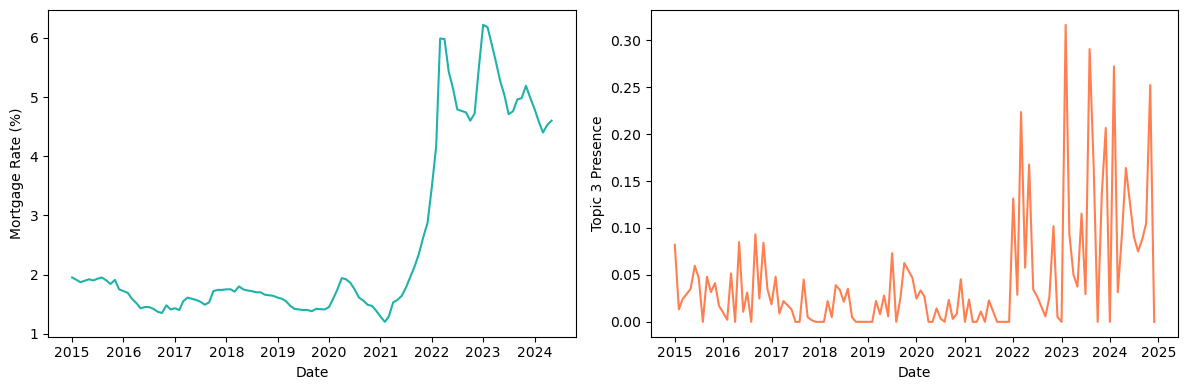

In [169]:
# Plot mortgage rates over time and Topic 3 over time
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(monthly_data['date'], monthly_data['mortgage_2yr_future_6m'], color='lightseagreen')
plt.xlabel('Date')
plt.ylabel('Mortgage Rate (%)')
# plt.title('Mortgage Rates Over Time')

plt.subplot(1,2,2)
plt.plot(monthly_data['date'], monthly_data['topic_3'], color='coral')
plt.xlabel('Date')
plt.ylabel('Topic 3 Presence')

plt.tight_layout()
plt.show()

**Observation:** Both topic 3 and mortgage rates surge in 2022.

In [171]:
# Subset and drop NA
clean_data = monthly_data[['date', 'topic_3', 'mortgage_2yr_future_6m']].dropna().copy()

**Note:** 2020, 2021, and 2022 have been tried as cutoff dates below.

In [174]:
cutoff_date = '2020-01-01'

# Split the data
pre_period = clean_data[clean_data['date'] < cutoff_date].copy()
post_period = clean_data[clean_data['date'] >= cutoff_date].copy()

# Print info about split
print(f"Full dataset: {len(clean_data)} observations")
print(f"Pre-2020: {len(pre_period)} observations")
print(f"Post-2020: {len(post_period)} observations")

# Option 1: Use the actual column names in formula
pre_model = ols('mortgage_2yr_future_6m ~ topic_3', data=pre_period).fit()
post_model = ols('mortgage_2yr_future_6m ~ topic_3', data=post_period).fit()

# Print summaries
print("\nPre Model:")
print(pre_model.summary())

print("\nPost Model:")
print(post_model.summary())

# Compare coefficients
print("\nCoefficient Comparison:")
print(f"Pre-2020 Topic 3 coefficient: {pre_model.params['topic_3']:.4f}")
print(f"Post-2020 Topic 3 coefficient: {post_model.params['topic_3']:.4f}")
print(f"Difference: {post_model.params['topic_3'] - pre_model.params['topic_3']:.4f}")

Full dataset: 108 observations
Pre-2020: 57 observations
Post-2020: 51 observations

Pre Model:
                              OLS Regression Results                              
Dep. Variable:     mortgage_2yr_future_6m   R-squared:                       0.008
Model:                                OLS   Adj. R-squared:                 -0.010
Method:                     Least Squares   F-statistic:                    0.4314
Date:                    Mon, 26 May 2025   Prob (F-statistic):              0.514
Time:                            17:14:51   Log-Likelihood:                 16.945
No. Observations:                      57   AIC:                            -29.89
Df Residuals:                          55   BIC:                            -25.80
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.

In [176]:
# Function to create regression plot
def create_split_regression_plot(model, data, period_name):
    x_values = data['topic_3']
    y_values = data['mortgage_2yr_future_6m']
    y_pred = model.predict()
    
    plt.figure(figsize=(5,5))
    plt.scatter(x_values, y_values, alpha=0.5, color='#56b779')
    plt.plot(x_values, y_pred, color='#4c4542', linewidth=2)
    
    plt.xlim(min(x_values) - 0.05, max(x_values) + 0.05)
    plt.ylim(min(y_values) - 0.1, max(y_values) + 0.1)
    
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    
    plt.xlabel('Topic 3 (Forecasting & Uncertainty Modelling)')
    plt.ylabel('6-Month Future Mortgage Rate')
    plt.title(f'{period_name}: Future Mortgage Rate x Topic 3')
    
    plt.tight_layout()
    plt.show()

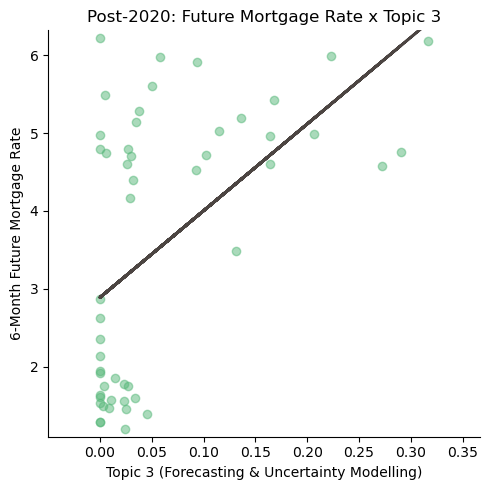

In [178]:
# Plot post time period
create_split_regression_plot(post_model, post_period, 'Post-2020')

**Observations:** 
- R-squared and coefficient increase in the post- period when the cutoff date is 2020, but remains low when the cutoff date is 2022 (when we really see a spike in topic 3, after the infamous mini-budget).
- This all seems fairly unstable, especially given that LDA topic modelling can be fuzzy and erratic.
- Topic 3 presence and mortgage rate increase both spike in 2022, suggesting they are both responding to the same market events rather than predicting each other.
- I will thus drop further exploration into this for now, especially as it doesn't fit well with our team's chosen approach with CBRoBERTa agents as a stronger story.
- However, this correlation between uncertainty modelling and mortgage rates in recent years may be something to keep in mind if it dovetails with other findings we unearth.